In [1]:
import pandas as pd

METADATA = "../data/metadata.csv"
S2W = "../data/Screen2Words_tfidf.csv"


MOST_POPULAR_CATEGORIES = ["Education","Business","Entertainment","Music & Audio","Food & Drink","Shopping","Lifestyle","Books & Reference","Health & Fitness","Finance"]

In [2]:
#import metadata and s2w dataset with tfidf score

metadata = pd.read_csv(METADATA)
metadata.drop(columns=["Unnamed: 0"], inplace=True)
metadata.rename(columns={"UI Number": "screenId"}, inplace=True)

s2w = pd.read_csv(S2W)
s2w.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
#add tfidf score to s2w dataset

metadata_tfidf = pd.merge(metadata, s2w[["screenId","tfidf_grouped_sum"]].drop_duplicates(), on="screenId")
metadata_tfidf = metadata_tfidf[metadata_tfidf['Category'].isin(MOST_POPULAR_CATEGORIES)]

In [4]:
#function, where each 20 samples from a dataframe are selected

def sampling_data (df, sample_amount=100):
    df['strata'] = pd.qcut(df['tfidf_grouped_sum'], sample_amount, labels=False)
    df = df.groupby('strata').apply(lambda x: x.sample(n=1))
    df = df.reset_index(drop=True)
    df = df.drop(columns=["strata"])
    return df

In [5]:
#spliting the datasframe into a set of dataframes based on the App category

categories = {k: v for k, v in metadata_tfidf.groupby('Category')}

for key, df in categories.items():
    # Apply the function to each DataFrame
    categories[key] = sampling_data(df)

    # You can store the result or print it
    print(f"sample for {key}")


sample for Books & Reference
sample for Business
sample for Education
sample for Entertainment
sample for Finance
sample for Food & Drink
sample for Health & Fitness
sample for Lifestyle
sample for Music & Audio
sample for Shopping


In [6]:
combined_sample = pd.concat(categories.values(), ignore_index=True)
combined_sample

,App Package Name,Play Store Name,Category,Average Rating,Number of Ratings,Number of Downloads,Date Updated,screenId,Interaction Trace Number,UI Number in Trace,split,tfidf_grouped_sum
0,br.com.casaopen.bibleBilingualSpanishEnglish,BIBLE SPANISH ENGLISH,Books & Reference,4.6,1721,"100,000 - 500,000","November 18, 2016",17500,0,555,train,7.577492
1,com.tecarta.TecartaBible,Tecarta Bible,Books & Reference,4.8,8118,"100,000 - 500,000","April 6, 2017",39009,0,54,train,7.927838
2,aa.apps.dailyreflections,Daily Reflections,Books & Reference,4.4,425,"50,000 - 100,000","November 15, 2016",11370,1,93,test,8.094383
3,tepteev.ihar.matthew_henry.AOUSZCZGSNUACBSGR,Matthew Henry Bible Commentary,Books & Reference,4.4,2391,"100,000 - 500,000","August 8, 2016",26955,0,414,train,8.142141
4,com.bravolang.english,Learn English,Books & Reference,4.3,91233,"5,000,000 - 10,000,000","December 3, 2016",29866,0,1039,train,8.246085
...,...,...,...,...,...,...,...,...,...,...,...,...
995,com.jcp,JCPenney,Shopping,4.2,14380,"1,000,000 - 5,000,000","November 4, 2016",25953,0,3924,test,10.964424
996,com.meamobile.printicular,Printicular Print Photos,Shopping,4.6,5319,"500,000 - 1,000,000","May 5, 2017",54998,0,362,train,11.036639
997,com.l,Smart Shopping List - Listonic,Shopping,4.6,24676,"1,000,000 - 5,000,000","May 12, 2017",60559,0,482,train,11.106840
998,com.kidizen,Kidizen: Buy Sell Kids Clothes,Shopping,4.1,350,"100,000 - 500,000","May 11, 2017",47018,0,202,train,11.317937


In [7]:
combined_sample["Category"].value_counts()

Category
Books & Reference    100
Business             100
Education            100
Entertainment        100
Finance              100
Food & Drink         100
Health & Fitness     100
Lifestyle            100
Music & Audio        100
Shopping             100
Name: count, dtype: int64

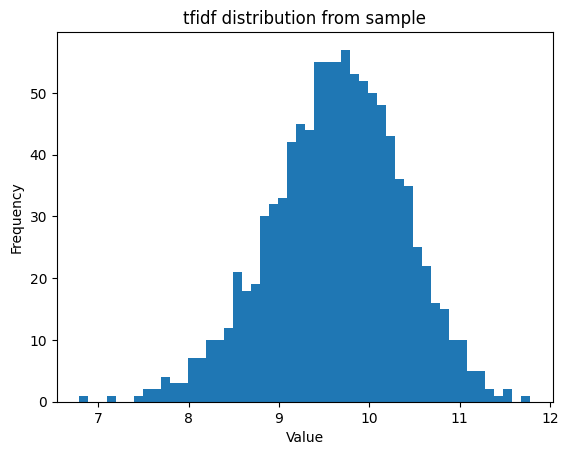

In [8]:
import matplotlib.pyplot as plt

data = combined_sample["tfidf_grouped_sum"]  # your large dataset
plt.hist(data, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('tfidf distribution from sample')
plt.show()

In [9]:
combined_sample.sort_values(by="screenId", inplace=True)
combined_sample.to_csv("../data/s2w_sample.csv")

In [10]:
metadata[metadata["Play Store Name"] == "Duolingo: Learn Languages Free"]

,App Package Name,Play Store Name,Category,Average Rating,Number of Ratings,Number of Downloads,Date Updated,screenId,Interaction Trace Number,UI Number in Trace,split
15465,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27727,1,2846,train
15466,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27729,1,1834,train
15467,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27730,1,3373,train
15468,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27731,1,2922,train
15469,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27732,1,2155,train
15470,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27733,1,3800,train
15471,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27734,1,1814,train
15472,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27735,1,2377,train
15473,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27737,1,732,train
15474,com.duolingo,Duolingo: Learn Languages Free,Education,4.7,4449253,"50,000,000 - 100,000,000","May 11, 2017",27738,1,4017,train


In [13]:
s2w[s2w["screenId"] == 13974]["summary"]

435    display page showing various options in weathe...
436                     page displaying various settings
437    screen displaying multiple setting options in ...
438    setting page displaying various options in wea...
439    settings page displaying various options in we...
Name: summary, dtype: object

In [15]:
from notebooks.prompts import SUMMARY_PROMPT_COT
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langfuse.callback import CallbackHandler
import os
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate


load_dotenv()
handler = CallbackHandler(os.environ.get("LANGFUSE_PUBLIC_KEY"), os.environ.get("LANGFUSE_SECRET_KEY"))

MODEL = "gpt-3.5-turbo"



In [16]:
def create_summaries_s2w(id, prompt=SUMMARY_PROMPT_COT, temp=0):
    llm = ChatOpenAI(model_name=MODEL,temperature=temp)

    chain = LLMChain(llm=llm, prompt=prompt, callbacks=[handler])

    summaries = s2w[s2w["screenId"]==id]["summary"].values
    summaries_str = "\n".join([f"Summary {i+1}: {summary}" for i, summary in enumerate(summaries)])

    try: 
        response = chain.run(summaries=summaries_str, callbacks=[handler])
    except Exception as e:
        print(e)
    return response

In [17]:
create_summaries_s2w(27729)

'Certainly, let\'s break it down step by step:\n\nSummary 1: "App asking to translate the given sentence" - This suggests that it\'s an app that prompts the user to translate a specific sentence.\n\nSummary 2: "Page displaying about translating the sentence" - This indicates that there is a page within the app that provides information about the process of translating the sentence.\n\nSummary 3: "Page displaying the translation" - This implies that there is a page within the app that displays the translated version of the sentence.\n\nSummary 4: "Page to translate the text" - Similar to Summary 1, it mentions a page dedicated to translating text.\n\nSummary 5: "Screen page of language translator application" - This suggests that it\'s a screen within a language translator application.\n\nFrom these summaries, we can formulate a new description:\n\nThe mobile page is part of a language translator application and serves as a page where users can input a sentence to be translated. It also